# **Delivery Dron Analysis**

# **Описание проекта**
Необходимо проанализировать данные о продажах иностранной интернет компании “Delivery Dron”, занимающейся продажей дронов доставщиков и работающей в четырех регионах c мая 2019 года.
# **Задачи**

*   сделать отчет о вложенных средствах
*   построить планы на следующий год
*   выяснить  в какой регион и какой рекламный канал инвестировать больше денег на привлечение клиентов в 2020 году





# **Описание данных**
Файл ecom_yl.csv содержит данные о визитах и покупках пользователей сайта интернет магазина “Delivery Dron”. Каждая строка представляет визит пользователя. Данные отсортированы по Session Date.

Столбцы набора данных:

    0: User Id - id пользователя    
    1: Region - регион визита    
    2: Device - устройство, с которого производится вход на сайт    
    3: Channel - рекламный канал перехода на сайт   
    4: Session Start - время начала пользовательской сессии (входа на сайт)
    5: Session End - время окончания пользовательской сессии (уход с сайта)
    6: SessionDurationSec - длительность сессии в секундах  
    7: Session Date - дата визита  
    8: Month - месяц визита   
    9: Day - день дня недели визита  
    10: Hour of day - час (от 0 до 24) визита    
    11: Order Dt - дата покупки   
    12: Revenue - сумма покупки    
    13: Payment Type - тип оплаты
    14: Promo code - использование промокода на скидку 10% (есть-1, нет-0).


# Шаг 0: Подготовка

## 0.1: Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import warnings
import scipy.stats as st

## 0.2: Константы и настройки

In [ ]:
warnings.filterwarnings('ignore')
TEST_SIZE = 0.15
RANDOM_STATE = 42

## 0.3: Загрузка данных

In [ ]:
df = pd.read_csv("data.csv", sep=",")
df.head()

,User Id,Region,Device,Channel,Session Start,Session End,SessionDurationSec,Session Date,Month,Day,Hour of day,Order Dt,Revenue,Payment Type,Promo code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


## 0.4: Пользовательские функции

In [ ]:
def get_ohe(data: pd.DataFrame, categories: list):
    '''
    Функция, которая переводит номинальные шкалы в бинарные методом OneHotEncoder.
    '''
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(data.dropna()[categories])

    temp_df = pd.DataFrame(data=ohe.transform(data[categories]), columns=ohe.get_feature_names_out())
    data = pd.concat([data.reset_index(drop=True), temp_df], axis=1)
    data = data.drop(columns=categories, axis=1)
    data.columns = data.columns.str.lower().str.replace(" ", "_")
    return data


def quantitative_analysis(data: pd.DataFrame, factor: str):
    '''
    Функция для анализа категориальных признаков и нахождения супервыбросов. Строит boxplot и hist.

    :param data: dataframe
    :param factor: название фактора
    :return: выводит два графика
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()

    sns.histplot(data[factor], kde=True, bins=24, ax=ax1)
    sns.boxplot(x=data[factor], ax=ax2)

    plt.suptitle(f"Гистограмма и ящик с усами для {factor}", fontsize=22, y=1.1)
    plt.show()


def get_quantile(data: pd.Series):
    '''
    Функция, которая возвращает границы интерквартильного размаха.

    :param data: фактор
    :return: нижняя граница интерквартильного размаха и верхняя
    '''
    # Вычисляем первый и третий квартили
    quantile_1 = data.quantile(0.25)
    quantile_3 = data.quantile(0.75)
    # Вычисляем интерквартильный размах (IQR)
    IQR = quantile_3 - quantile_1
    lower_bound = quantile_1 - 1.5 * IQR
    upper_bound = quantile_3 + 1.5 * IQR

    return lower_bound, upper_bound


def print_pie(df, factor):
    df1 = pd.DataFrame(df.groupby([factor])[factor].count())
    plt.figure(figsize=(4, 4))
    plt.pie(x=df1[factor], labels=df1.index, autopct='%1.1f%%')
    plt.suptitle(factor, fontsize=15)
    plt.show()


def print_double_pie(df, div_factor, factor):
    df_1_1 = pd.DataFrame(df[df[div_factor] == 0].groupby([factor])[factor].count())
    df_1_2 = pd.DataFrame(df[df[div_factor] == 1].groupby([factor])[factor].count())

    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(8,4))

    ax1.pie(x=df_1_1[factor], labels=df_1_1.index, autopct='%1.1f%%')
    ax1.set_title(f"Not {div_factor}", y=-0.1)

    ax2.pie(x=df_1_2[factor], labels=df_1_2.index, autopct='%1.1f%%')
    ax2.set_title(div_factor, y=-0.1)

    fig.suptitle(f'Distribution of Payers by {factor}', fontsize=18)
    plt.show()


def regression_visual(X_test, y_test, predictions, metric):
    data = pd.DataFrame({metric: X_test[metric], 'y_test': y_test, 'predictions': predictions})
    data.sort_values(by=metric, inplace=True)

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')
    sns.regplot(data=data, x=metric, y='y_test')
    plt.xlabel(f'Количество сессий с использованием {metric}')
    plt.ylabel('Количество покупок в месяц')
    plt.title(f'Количество покупок в месяц относительно количества сессий с использованием {metric}')
    plt.show()

# **Шаг 1: Общий анализ данных и предобработка**

## 1.0: Столбцы
Приведём столбцы к формату PEP8 и переименуем некоторые из них.

In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")  # PEP8
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1012 non-null   int64  
 1   region              999 non-null    object 
 2   device              999 non-null    object 
 3   channel             999 non-null    object 
 4   session_start       1012 non-null   object 
 5   session_end         1012 non-null   object 
 6   sessiondurationsec  1012 non-null   float64
 7   session_date        1012 non-null   object 
 8   month               1012 non-null   int64  
 9   day                 1012 non-null   int64  
 10  hour_of_day         1012 non-null   int64  
 11  order_dt            285 non-null    object 
 12  revenue             285 non-null    float64
 13  payment_type        285 non-null    object 
 14  promo_code          285 non-null    float64
dtypes: float64(3), int64(4), object(8)
memory usage: 118.7+

In [ ]:
df.columns = df.columns.str.replace("sessiondurationsec", "session_duration_sec")
df.columns = df.columns.str.replace("order_dt", "order_date")
df.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end', 'session_duration_sec', 'session_date', 'month', 'day',
       'hour_of_day', 'order_date', 'revenue', 'payment_type', 'promo_code'],
      dtype='object')

## 1.1: Обработка данных

### region
Уберём опечатки и пустые строки.
Пустые строки необходимо убрать, потому что нам важен регион.
Пропуски могут быть в столбцах, отвечающих за покупку, ведь покупка может быть не совершена.

In [ ]:
df["region"].unique()

array(['United States', 'Frаnce', 'Unjted States', 'Germany', 'UK',
       'France', 'Frаncе', 'Franсe', 'germany', nan, 'UК'], dtype=object)

In [ ]:
corrections = {
    "Unjted States": "United States",
    "germany": "Germany",
    "Frаncе": "France",
    "UК": "UK",
    "Frаnce": "France",
    "Franсe": "France"
}

df["region"] = df["region"].replace(corrections)
df = df.dropna(subset=['region'])
df["region"].value_counts()

region
United States    679
UK               115
France           103
Germany          102
Name: count, dtype: int64

In [ ]:
REGIONS = df["region"].unique()

### device

Уберём опечатки

In [ ]:
df["device"].unique()

array(['iPhone', 'PC', 'Mac', 'Android', 'android'], dtype=object)

In [ ]:
df["device"] = df["device"].replace("android", "Android")

In [ ]:
DEVICES = df["device"].unique()

### channel
Уберем опечатки и поменяем название термина organic на русский "без рекламы"

In [ ]:
df["channel"].unique()

array(['социальные сети', 'organic', 'реклама у блогеров',
       'контексная реклама', 'email-рассылки', 'контекстная реклама'],
      dtype=object)

In [ ]:
df["channel"] = df["channel"].replace("контексная реклама", "контекстная реклама")
df["channel"] = df["channel"].replace("organic", "без рекламы")

In [ ]:
CHANNELS = df["channel"].unique()

### payment_type
Всё в порядке

In [ ]:
df["payment_type"].unique()

array(['Mobile payments', nan, 'Debit card', 'E-wallet', 'Cash',
       'Credit card'], dtype=object)

### session_start, session_end, session_date, order_dt
Переведём тип данных столбцов с датой и временем в соответствующий формат

In [ ]:
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

### promo_code
Уберем строки, где наличие промокода непонятно (0.862715)

In [ ]:
df["promo_code"].value_counts()

promo_code
0.000000    196
1.000000     78
0.862715      3
Name: count, dtype: int64

In [ ]:
df = df[(df['promo_code'] == 0) | (df['promo_code'] == 1) | (df['promo_code'].isna())]
# df["promo_code"].astype(int) - NaN не может быть интом

### revenue
Удалим супервыбросы

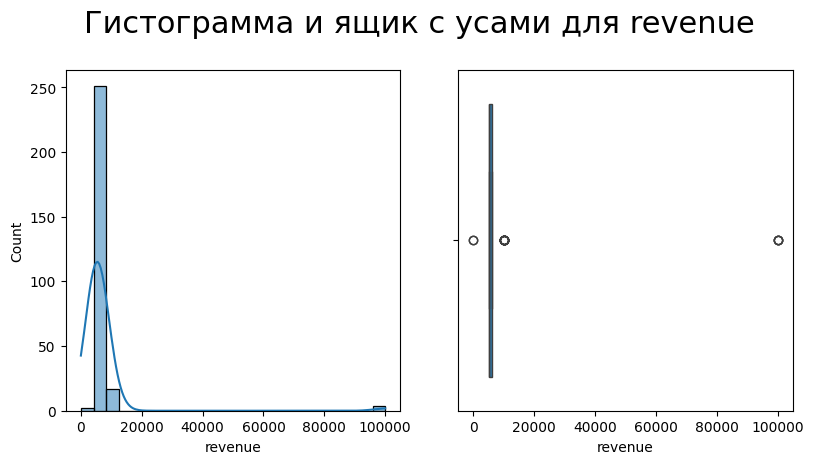

In [ ]:
quantitative_analysis(df[df["revenue"].notna()], "revenue")

In [ ]:
low, up = get_quantile(df[df["revenue"].notna()]["revenue"])
df = df[((df["revenue"] >= low) & (df["revenue"] <= up)) | (df["revenue"].isna())]
df["revenue"].value_counts()

revenue
4999.0    185
5999.0     66
Name: count, dtype: int64

### session_duration_sec

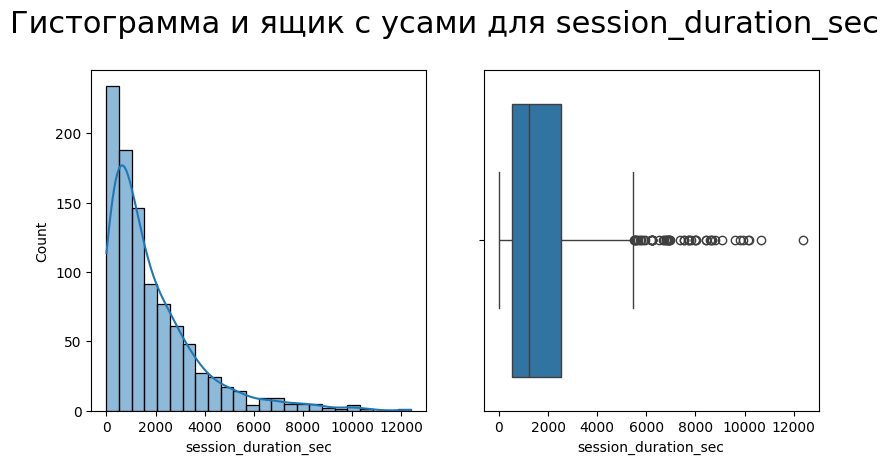

In [ ]:
quantitative_analysis(df, "session_duration_sec")

In [ ]:
low, up = get_quantile(df["session_duration_sec"])
df = df[(df["session_duration_sec"] >= low) & (df["session_duration_sec"] <= up)]

### Сброс индексов

In [ ]:
df.reset_index(drop=True, inplace=True)

## 1.2: Новые метрики

### revenue_with_discount
Итоговая сумма покупки с учетом применения промокода на скидку 10%

In [ ]:
df['revenue_with_discount'] = df['revenue'] * (1 - df['promo_code'] * 0.1)
df.head()

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount
0,601292388085,United States,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN
1,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN
2,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN
3,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN
4,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN


### time_of_day

Временя суток визита

In [ ]:
def part_of_day(hour):
    if 6 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 17:
        return 'day'
    elif 17 <= hour < 22:
        return 'evening'
    return 'night'


df['time_of_day'] = df['hour_of_day'].apply(part_of_day)

### payer

столбец с информацией о том, является ли пользователь платящим или нет

In [ ]:
df['payer'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)

## 1.3: Дубликаты

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## 1.4: Проверка дат на соотвствие

In [ ]:
df = df[(df['order_date'] >= df['session_start']) & (df['order_date'] <= df['session_end']) | (df["payer"] == 0)]
df.reset_index(drop=True, inplace=True)

## Выводы по первому шагу

- Столбы приведены к формату PEP8
- Выявлены и убраны опечатки в категориальных данных
- Убраны пропуски, где необходимо
- Убраны строки с некорректными данными
- Убраны супервыбросы
- Убраны дубликаты
- Перевод данных в соответствующий формат
- Новые метрики

In [ ]:
df.to_csv("preprocessed_data.csv")
print(f"Size - {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Size - 920 rows and 18 columns.


,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
0,601292388085,United States,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN,morning,0
1,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN,night,0
2,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN,evening,0
3,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN,day,0
4,271758921583,United States,iPhone,социальные сети,2019-05-02 08:40:35,2019-05-02 08:41:15,40.0,2019-05-02,5,4,8,NaT,NaN,NaN,NaN,NaN,morning,0


# **Шаг 2: Аналитический и графический анализ данных**

### 2.1) Доля продаж по регионам

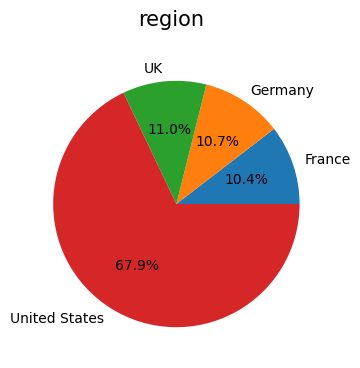

In [ ]:
print_pie(df, "region")

***Вывод:*** США является главным регионом продаж с долей в 67.9%. Другие страны Европы: Великобритания, Германия и Франция имеют примерно равные доли рынка 11%, 10.7% и 10.4% соответственно.

### 2.2) Доля продаж по источникам

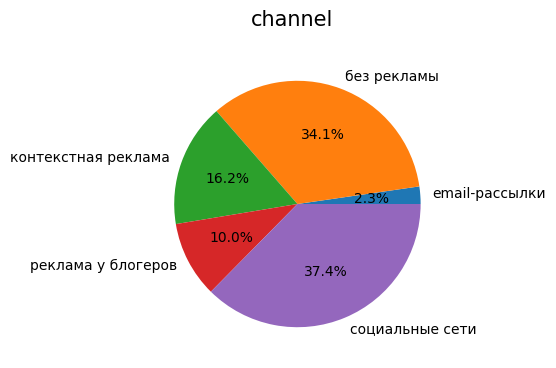

In [ ]:
print_pie(df, "channel")

***Вывод:*** Основной вклад в продажи вносят социальные сети с долей в 37.4%. За ними следует контекстная реклама с долей 16.2%. Реклама у блогеров занимает третье место с долей в 10%, а email-рассылки имеют самую низкую долю продаж в 2.3%. При этом на рекламу не приходится целых 34.1% от общего объема продаж, что подчеркивает важность использования других, более эффективных каналов привлечения клиентов.(Например, телевидение/радио/пресса/выставки и конференции/участие в партнерских программах/акции и специальные предложения/SEO-оптимизация сайта)

### 2.3) Доля продаж по устройствам

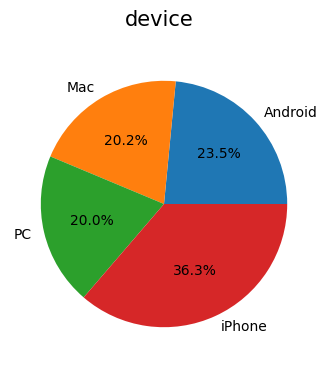

In [ ]:
print_pie(df, "device")

***Вывод:*** Наибольшая доля продаж приходится на iPhone - 36.3%, за ним следует Android - 23.5%. Устройства Mac и PC имеют примерно равные доли рынка в 20.2% и 20%.

### 2.4) Количество пользователей с разбивкой на платящих/не платящих по регионам

payer            0    1
region                 
France          74   22
Germany         76   22
UK              76   25
United States  464  161


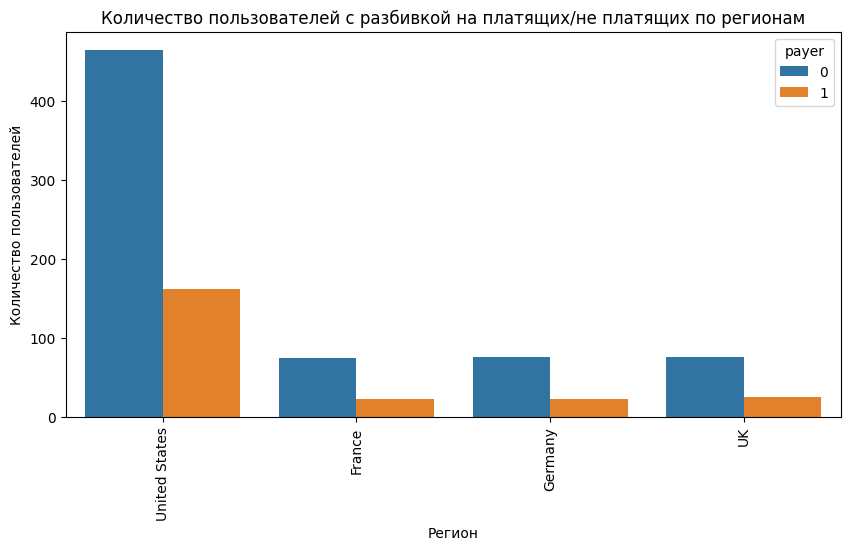

In [ ]:
region_payers = df.groupby(['region', 'payer']).size().unstack()
print(region_payers)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['region'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()

***Вывод:*** Наибольшее количество плательщиков проживает в Соединенных Штатах (161), за ними следуют Великобритания (25), Германия и Франция с равным количеством человек(22).

Наибольшее количество неплательщиков также проживает в Соединенных Штатах (464), за ними идут Великобритания и Германия с равным количеством человек (76), затем Франция (74).

Общее количество пользователей больше всего в США, что может объяснить набольшое количество и плательщиков, и неплательщиков в этой стране.


### 2.5) Количество пользователей с разбивкой на платящих/не платящих по устройствам

payer      0   1
device          
Android  155  61
Mac      137  49
PC       142  42
iPhone   256  78


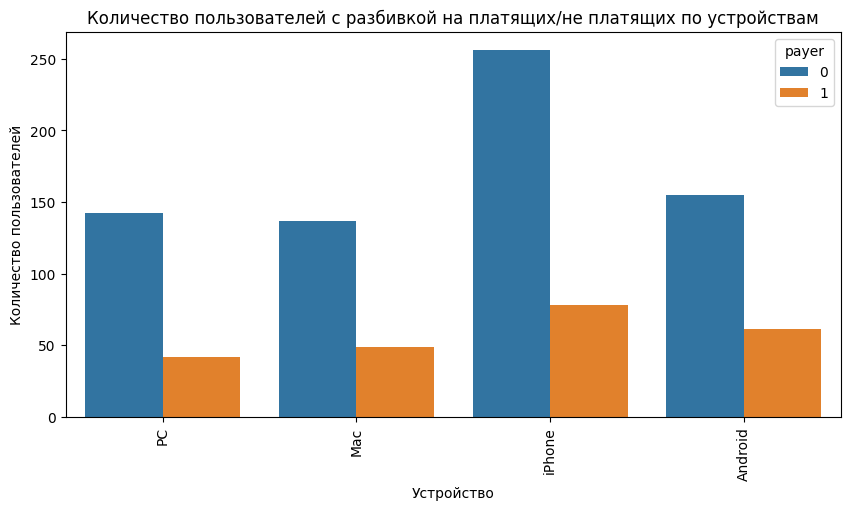

In [ ]:
device_payers = df.groupby(['device', 'payer']).size().unstack()
print(device_payers)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['device'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по устройствам')
plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()


***Вывод:*** Наибольшее количество плательщиков обладатели Iphone (78), за ними следуют пользователи Android (61), Mac и PC используют (49) и (42) плательщика.

Наибольшее количество неплательщиков обладатели Iphone (256), за ними следуют пользователи Android (155), Mac и PC используют (137) и (142) неплательщика.

Общее количество пользователей iPhone и Android также больше, чем Mac и PC, что может объяснить более высокое количество плательщиков среди этих устройств.



### 2.6) Количество пользователей с разбивкой на платящих/не платящих по источникам

payer                  0   1
channel                     
email-рассылки        15   6
без рекламы          248  66
контекстная реклама  109  40
реклама у блогеров    67  25
социальные сети      251  93


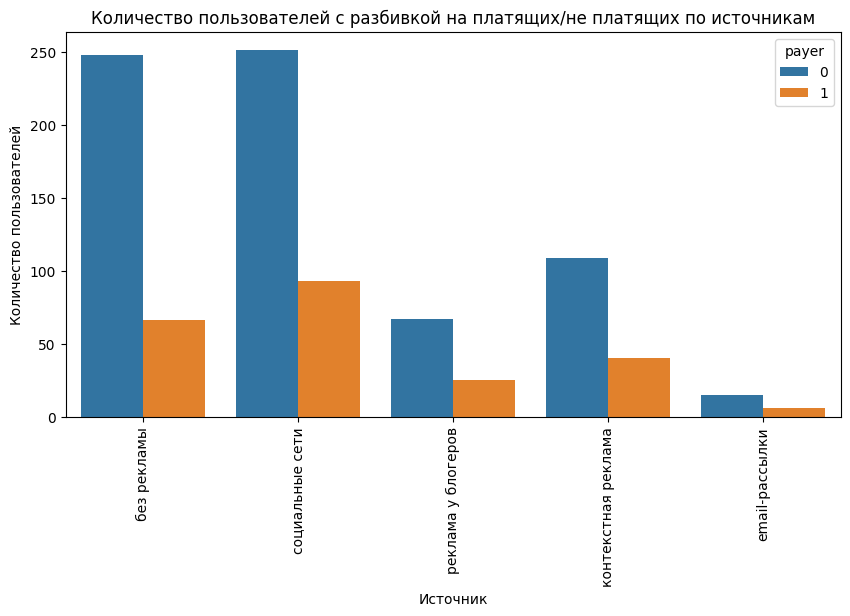

In [ ]:
channel_payers = df.groupby(['channel', 'payer']).size().unstack()
print(channel_payers)
plt.figure(figsize=(10, 5))
sns.countplot(x=df['channel'], hue=df['payer'])
plt.title('Количество пользователей с разбивкой на платящих/не платящих по источникам')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=90)
plt.show()

***Вывод:***   Наибольшее количество плательщиков предпочитают получать информацию из социальных сетей (93) и контекстной рекламы (40). Реклама у блогеров и email-рассылки привлекли (25) и (6) человек. Почти 29% плательщиков в размере (66) человек пришли без рекламы.

Наибольшее количество неплательщиков предпочитают получать информацию из социальных сетей (251) и контекстной рекламы (109). Реклама у блогеров и email-рассылки привлекли (67) и (15) человек. Почти 36% неплательщиков в размере (248) человек пришли без рекламы.


### 2.7) График сезонности в продажах по месяцам  

month
5     101981.0
6     218959.0
7     202961.0
8     302943.0
9     179965.0
10    202961.0
Name: revenue, dtype: float64


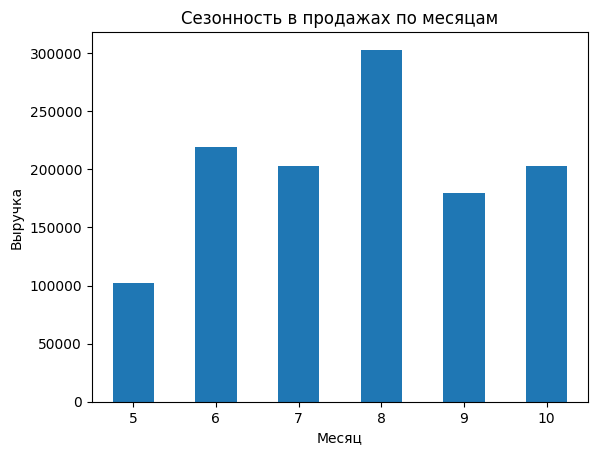

In [ ]:
month_rev = df.groupby('month')['revenue'].sum()
print(month_rev)
month_rev.plot(kind='bar')
plt.title('Сезонность в продажах по месяцам')
plt.xlabel('Месяц')
plt.xticks(rotation=0)
plt.ylabel('Выручка')
plt.show()


***Вывод:*** Самым прибыльным месяцем был август, выручка составила (302943), что в три раза превышает самую маленькую выручку - в мае (101981). Июнь, июль и октябрь имели примерно равную вырочку в (218959), (202961) и (202961). В сентябре выручка была средней - (179965). В летние месяцы (июнь, июль, август) была заметна стабильная и большая выручка.

### 2.8) График сезонности в продажах по дням недели

day
1    187964.0
2    178966.0
3    166969.0
4    153970.0
5    208961.0
6    177966.0
7    134974.0
Name: revenue, dtype: float64


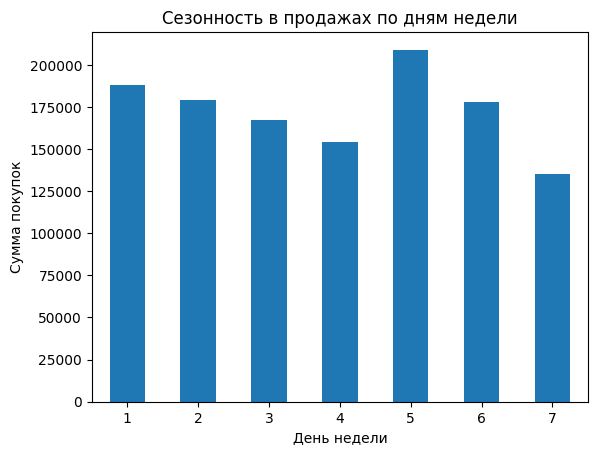

In [ ]:
day_rev = df.groupby('day')['revenue'].sum()
print(day_rev)
day_rev.plot(kind='bar')
plt.title('Сезонность в продажах по дням недели')
plt.xlabel('День недели')
plt.xticks(rotation=0)
plt.ylabel('Сумма покупок')
plt.show()

***Вывод:*** Самый прибыльный день недели - пятница (208961), за ней следует понедельник (187964). Самая маленькая прибыль по воскресеньям (134974). Есть тенденция снижения прибыли с понедельника по четверг, затем большая выручка в пятницу и снова снижение дохода до воскресенья.

### 2.9) График сезонности в продажах по времени суток

time_of_day
day        299943.0
evening    273948.0
morning    222957.0
night      412922.0
Name: revenue, dtype: float64


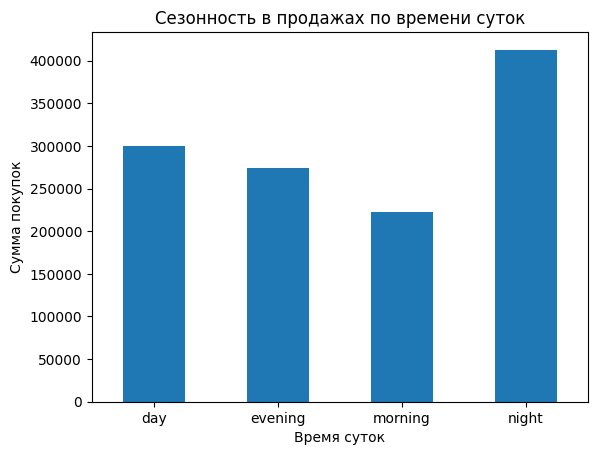

In [ ]:
time_rev = df.groupby('time_of_day')['revenue'].sum()
print(time_rev)
time_rev.plot(kind='bar')
plt.title('Сезонность в продажах по времени суток')
plt.xlabel('Время суток')
plt.xticks(rotation=0)
plt.ylabel('Сумма покупок')
plt.show()

***Вывод:*** Самое прибыльное время суток - ночь(с 22 ночи до 6 утра) (412922). Наименьшая прибыль, которая в 1.85 раза меньше ночной,  зафиксирована утром (с 6 до 10 утра) (222957).

### 2.10) Диаграмма количества покупок по типу оплаты

payment_type
Mobile payments    64
E-wallet           55
Cash               53
Credit card        30
Debit card         28
Name: count, dtype: int64


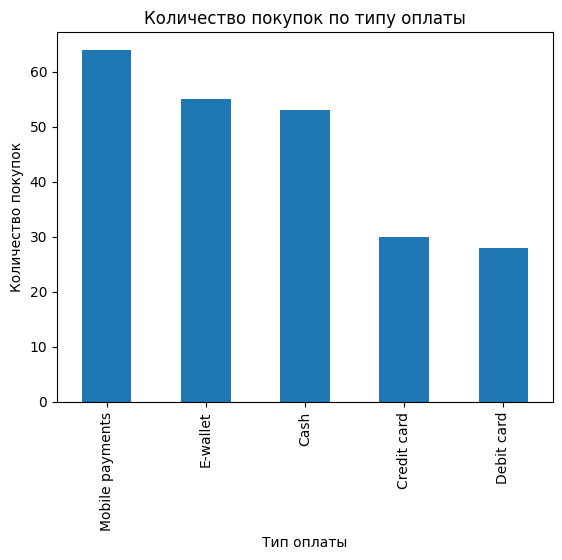

In [ ]:
pay_count = df['payment_type'].value_counts()
print(pay_count)
pay_count.plot(kind='bar')
plt.title('Количество покупок по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество покупок')
plt.show()

***Вывод:*** Самым популярным способом оплаты являются мобильные платежи (64). Затем идут электронные кошельки (55) и наличные (53). Кредитными и дебетовыми картами пользуются реже всего: (30) и (28). Возможно, это связано с ростом популярности мобильных приложений для оплаты и удобством использования электронных кошельков. Тем не менее, оплата наличными также остается популярным способом оплаты.

# **Шаг 3: Проведение расчетов**

### 3.1) Средний чек

In [ ]:
av_check = df['revenue'].mean()
print(av_check)

5259.869565217391


### 3.2) средняя продолжительность сессии по рекламным каналам

# Шаг 4: Проверка гипотез

### 4.1: Влияет ли тип устройства на количество покупок в день по каждому региону?

Из приведённого ниже графика мы можем сделать следующие вывод:
В регионах разница несущественная, тк p-value слишком большое.

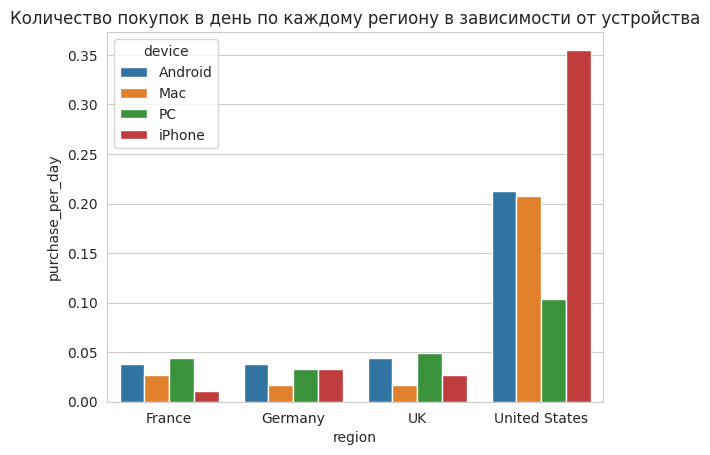

In [ ]:
orders = df[df['order_date'].notnull()]
days_count = (df["session_date"].max() - df["session_date"].min()).days # количество дней в диапазоне дат

grouped_data = orders.groupby(['region', 'device']).size().apply(
    lambda x: x / days_count
).reset_index(name='purchase_per_day')

sns.barplot(data=grouped_data, x='region', y='purchase_per_day', hue='device')
plt.title("Количество покупок в день по каждому региону в зависимости от устройства")
plt.show()

### 4.2: Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

Из приведённого ниже графика мы можем сделать следующие выводы:

1) В Америке чаще всего совершают покупки те, кто узнал о магазине через социальные сети. Разница между каналами рекламы очень существенная. Реклама у блогеров и контекстная реклама не приносят столько же, поэтому, возможно, следует отказаться от этих способов. Также многие покупатели узнают о магазине не из рекламы.
2) В остальных регионах о магазине не узнают из соц сетей. На примере Америки, это был самый эффективный способ рекламы магазина, поэтому стоит попробовать рекламировать магазин через соцальные сети и в других регионах.
3) В Германии, Великобритании и Франции самый эффективный канал рекламы - контекстная реклама.
4) Email-рассылки - самый неэффективный канал рекламы. Возможно, следует отказаться от этого способа.

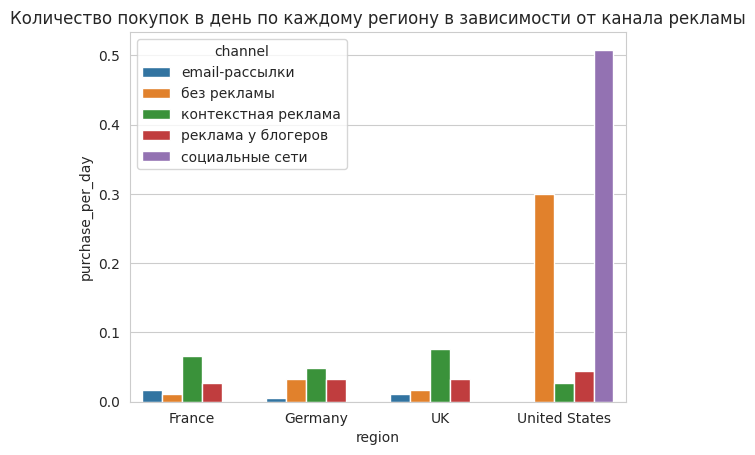

In [ ]:
grouped_data = orders.groupby(['region', 'channel']).size().apply(
    lambda x: x / days_count
).reset_index(name='purchase_per_day')

sns.barplot(data=grouped_data, x='region', y='purchase_per_day', hue='channel')
plt.title("Количество покупок в день по каждому региону в зависимости от канала рекламы")
plt.show()

### 4.3: Cредний чек отличается в зависимости от региона?

Нет, средний чек примерно одинаковый.

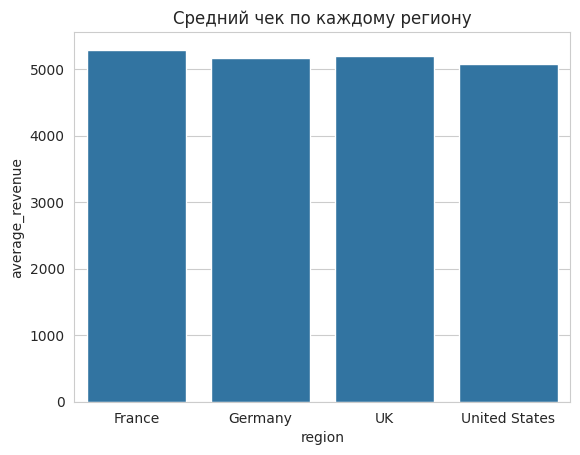

In [ ]:
grouped_data = orders.groupby('region')["revenue_with_discount"].mean().reset_index(name='average_revenue')

sns.barplot(data=grouped_data, x='region', y='average_revenue')
plt.title("Средний чек по каждому региону")
plt.show()

### 4.4: Cредний чек отличается в зависимости от рекламного канала?

### 4.5: Cредний чек отличается в зависимости от времени суток?

### 4.6: Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?

### 4.7: Придумать

### 4.8: Придумать

# Шаг 5: Регрессионное моделирование

## 5.1: Все регионы

### 5.1.0: Подготовка

Чтобы понять, насколько развивается бизнес, требуется:

- Добавить фактор, выражающий количество покупок ежемесячно.
- Посчитать, сколько раз встречаются уникальные значения номинальных шкал ежемесячно.
- Убрать неподходящие для обучения шкалы (id, номинальные и даты)

In [ ]:
month_purchases = df[df["payer"] == 1].groupby("month")["revenue_with_discount"].count()

timestamp_columns = df.select_dtypes(include=['datetime64']).columns
nominal_columns = df.select_dtypes(include=[object]).columns

regr_df = df.drop(columns=[*timestamp_columns, "user_id", "revenue"])
regr_df["month_revenue"] = regr_df["month"].map(month_purchases)

channels = regr_df.groupby("month")["channel"].value_counts().unstack(fill_value=0)
for channel in df["channel"].unique():
    regr_df[channel.replace(" ", "_")] = regr_df["month"].map(channels[channel])

devices = regr_df.groupby("month")["device"].value_counts().unstack(fill_value=0)
for device in df["device"].unique():
    regr_df[device.replace(" ", "_").lower()] = regr_df["month"].map(devices[device])
'''
regions = regr_df.groupby("month")["region"].value_counts().unstack(fill_value=0)
for region in df["region"].unique():
    regr_df[region.replace(" ", "_").lower()] = regr_df["month"].map(regions[region])
'''
regr_df.drop(columns=nominal_columns, inplace=True)

### 5.1.1: Выбор факторов

Чтобы понять, какие факторы влияют на целевой фактор (количество покупок ежемесячно), необходимо узнать коэф-ы корреляций. Возьмём самый большой по модулю.

In [ ]:
correlations = regr_df.corr()["month_revenue"].sort_values(key=abs, ascending=False)
top_correlations = correlations[abs(correlations) >= 0.5][1:]
top_correlation = top_correlations.index[0]
top_correlations

android                0.644018
контекстная_реклама    0.639137
реклама_у_блогеров     0.590261
iphone                 0.564493
Name: month_revenue, dtype: float64

### 5.1.2: Модель

Разделим выборку на тренировочную и тестовую. Подставим в модель линейной регрессии тренировочную.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    regr_df[[top_correlation]], regr_df["month_revenue"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
model.fit(X_train, y_train)
print("Модель линейной регрессии")

Модель линейной регрессии


### 5.1.3: Предсказание

Из полученных метрик, можно сделать вывод, что наша модель относительно точная.

In [ ]:
predictions = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 7.234085269244517
MSE: 68.28308132245661
R^2: 0.34460333936883547


### 5.1.4: Корреляция предсказания и реальных данных

Из полученных данных, можно убедиться, что наша модель относительно точная.

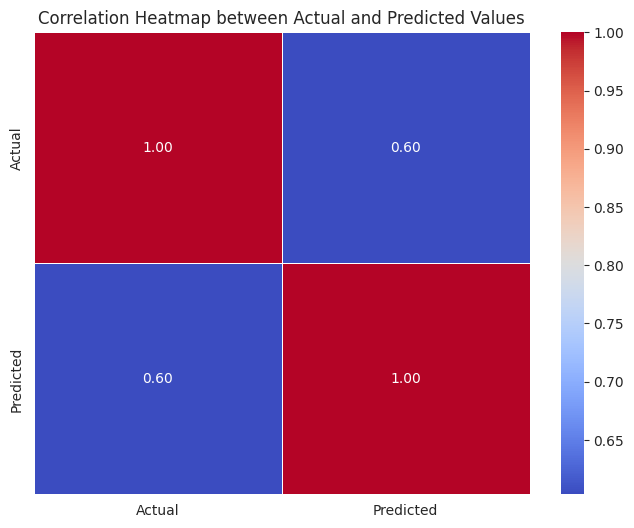

In [ ]:
prediction_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prediction_vs_actual_corr = prediction_vs_actual.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(prediction_vs_actual_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Actual and Predicted Values')
plt.show()

### 5.1.5: Регрессия графически

Мы, в целом, видим, что продажи растут для пользователей Android.

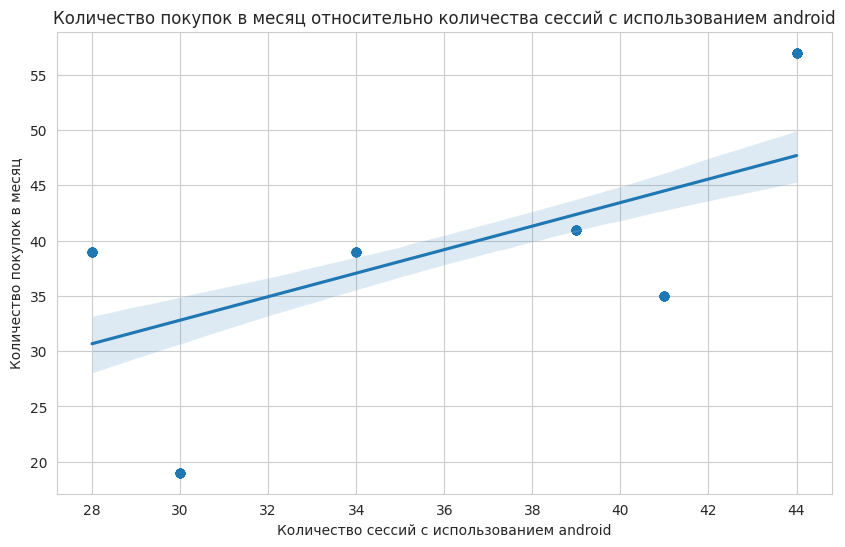

In [ ]:
regression_visual(X_test, y_test, predictions, top_correlation)

### Вывод

Продажи растут. Возможно, стоит рекламировать разные продукты для пользователей разных устройств. Стоит развивать рекламу для пользователей Andoid, потому что они занимают значимую часть в каждом регионе.

## 5.2: Регион United States

Я считаю, что регион United States нужно рассмотреть отдельно, тк в этом регионе самые большие продажи.

### 5.2.0: Подготовка

Чтобы понять, насколько развивается бизнес, требуется:

- Добавить фактор, выражающий количество покупок ежемесячно.
- Посчитать, сколько раз встречаются уникальные значения номинальных шкал ежемесячно.
- Убрать неподходящие для обучения шкалы (id, номинальные и даты)

In [ ]:
month_purchases = df[(df["payer"] == 1) & (df["region"] == "United States")].groupby("month")["revenue_with_discount"].count()

regr_df = df[df["region"] == "United States"].drop(columns=[*timestamp_columns, "user_id", "revenue"])
regr_df["month_revenue"] = regr_df["month"].map(month_purchases)

channels = regr_df.groupby("month")["channel"].value_counts().unstack(fill_value=0)
for channel in df[df["region"] == "United States"]["channel"].unique():
    regr_df[channel.replace(" ", "_")] = regr_df["month"].map(channels[channel])

devices = regr_df.groupby("month")["device"].value_counts().unstack(fill_value=0)
for device in df[df["region"] == "United States"]["device"].unique():
    regr_df[device.replace(" ", "_").lower()] = regr_df["month"].map(devices[device])

regr_df.drop(columns=nominal_columns, inplace=True)

### 5.2.1: Выбор факторов

Чтобы понять, какие факторы влияют на целевой фактор (количество покупок ежемесячно), необходимо узнать коэф-ы корреляций. Возьмём самый большой по модулю.

In [ ]:
correlations = regr_df.corr()["month_revenue"].sort_values(key=abs, ascending=False)
top_correlations = correlations[abs(correlations) >= 0.45][1:]
top_correlation = top_correlations.index[1]
top_correlations

mac                0.552627
социальные_сети    0.552336
month              0.512025
без_рекламы       -0.468447
Name: month_revenue, dtype: float64

### 5.2.2: Модель

Разделим выборку на тренировочную и тестовую. Подставим в модель линейной регрессии тренировочную.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    regr_df[[top_correlation]], regr_df["month_revenue"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
model.fit(X_train, y_train)
print("Модель линейной регрессии")

Модель линейной регрессии


### 5.2.3: Предсказание

Из полученных метрик, можно сделать вывод, что наша модель относительно точная.

In [ ]:
predictions = model.predict(X_test)

mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 5.9287173990454916
MSE: 41.98019422258229
R^2: 0.32063318922437


### 5.2.4: Корреляция предсказания и реальных данных

Из полученных данных, можно убедиться, что наша модель относительно точная.

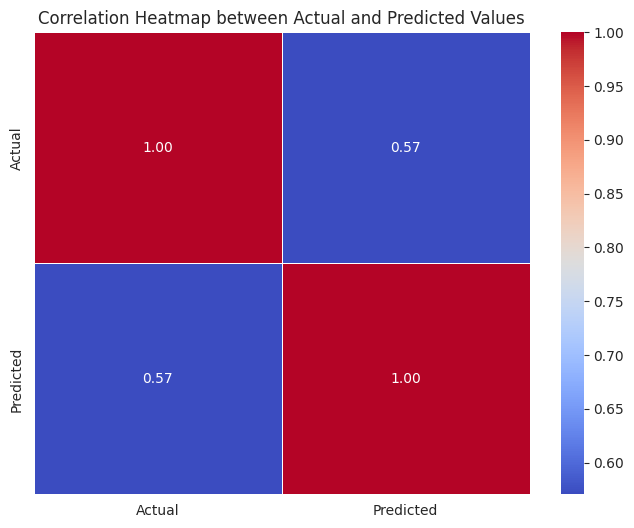

In [ ]:
prediction_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prediction_vs_actual_corr = prediction_vs_actual.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(prediction_vs_actual_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Actual and Predicted Values')
plt.show()

### 5.2.5: Регрессия графически

Мы, в целом, видим, что продажи растут для пользователей, узнавших про магазин через социальные сети.

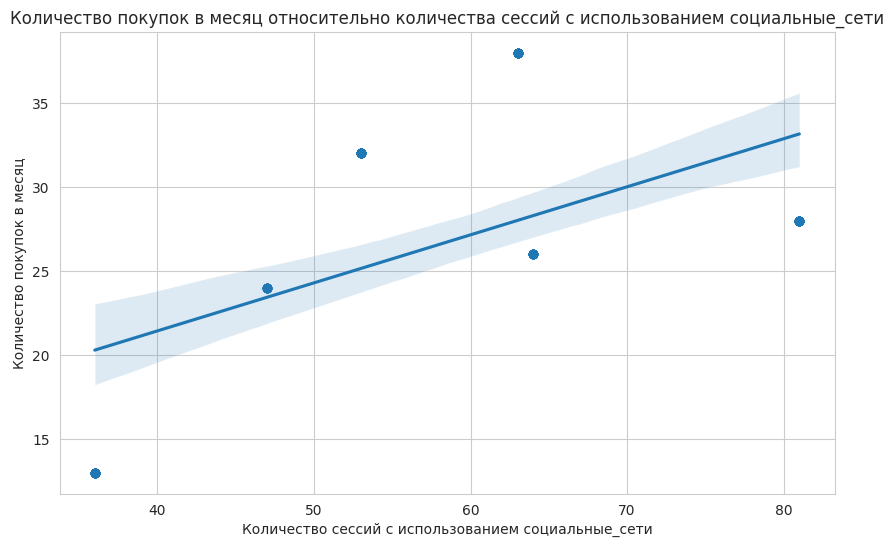

In [ ]:
regression_visual(X_test, y_test, predictions, top_correlation)

### Вывод

Стоит развивать рекламу в социальных сетях (и не только в Америке), потому что продажи растут.